In [2]:
import os
import warnings
import tensorflow as tf

# Supress warnings agar output lebih bersih
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# --- KONFIGURASI GPU (WAJIB UNTUK LOKAL) ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Mengatur memory growth agar tidak langsung memakan 100% VRAM
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU Terdeteksi & Siap: {gpus[0].name}")
    except RuntimeError as e:
        print(e)
else:
    print("⚠️ GPU Tidak terdeteksi. Menggunakan CPU.")

⚠️ GPU Tidak terdeteksi. Menggunakan CPU.


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, models, Model
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# --- KONFIGURASI HYPERPARAMETER (OPTIMAL) ---
# Berdasarkan Paper Referensi 
LEARNING_RATE = 0.000506
NEURONS_FLN = 471
DROPOUT_RATE = 0.44
BATCH_SIZE = 16   # Sesuaikan dengan VRAM (8, 16, atau 32)
EPOCHS = 30       # Epoch maksimal (akan berhenti jika early stopping aktif)
IMG_SIZE = (224, 224)
NUM_CLASSES = 3   # Benign, Malignant, Normal

# Path Dataset - Struktur: DATA_DIR/train, DATA_DIR/validation, DATA_DIR/test
DATA_DIR = "D:\\Kuliah\\Semester 5\\HUMIC\\dataset gabungan"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "validation")
TEST_DIR = os.path.join(DATA_DIR, "test")


In [4]:
def preprocessing_clahe_densenet(img):
    """
    Pipeline Preprocessing:
    1. Convert ke LAB Color Space
    2. Terapkan CLAHE pada channel L (Lightness)
    3. Convert balik ke RGB
    4. Normalisasi standar DenseNet (tf.keras.applications.densenet.preprocess_input)
    """
    # Pastikan format uint8
    img = img.astype('uint8')
    
    # 1. RGB -> LAB
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    
    # 2. Terapkan CLAHE (ClipLimit 2.0, Grid 8x8 sesuai paper) [cite: 98]
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    
    # 3. Gabungkan & Balik ke RGB
    limg = cv2.merge((cl, a, b))
    final_img = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    
    # 4. Normalisasi DenseNet (Scaling input ke range spesifik ImageNet)
    final_img = tf.keras.applications.densenet.preprocess_input(final_img)
    
    return final_img

In [5]:
# Setup Generator dengan Augmentasi untuk Training
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocessing_clahe_densenet, # Custom Function di atas
    rotation_range=20,        # Rotasi [cite: 108]
    width_shift_range=0.1,    # Geser Horizontal [cite: 109]
    height_shift_range=0.1,   # Geser Vertikal
    horizontal_flip=True,     # Valid secara medis [cite: 110]
    vertical_flip=False,      # JANGAN vertical flip (Bayangan akustik) [cite: 112]
    zoom_range=0.2,           # Simulasi ukuran tumor [cite: 114]
    shear_range=0.1,
    fill_mode='nearest'
)

# Generator untuk Validation & Test (HANYA preprocessing, tanpa augmentasi)
val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocessing_clahe_densenet
)

print("Menyiapkan Training Generator...")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

print("\nMenyiapkan Validation Generator...")
val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("\nMenyiapkan Test Generator...")
test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Cek Mapping Kelas
class_names = list(train_generator.class_indices.keys())
print(f"\nLabel Kelas: {class_names}")
print(f"Total data training: {train_generator.samples}")
print(f"Total data validasi: {val_generator.samples}")
print(f"Total data test: {test_generator.samples}")


Menyiapkan Training Generator...
Found 824 images belonging to 3 classes.

Menyiapkan Validation Generator...
Found 113 images belonging to 3 classes.

Menyiapkan Validation Generator...
Found 113 images belonging to 3 classes.

Menyiapkan Test Generator...
Found 93 images belonging to 3 classes.

Label Kelas: ['benign', 'malignant', 'normal']
Total data training: 824
Total data validasi: 113
Total data test: 93

Menyiapkan Test Generator...
Found 93 images belonging to 3 classes.

Label Kelas: ['benign', 'malignant', 'normal']
Total data training: 824
Total data validasi: 113
Total data test: 93


In [6]:
def build_densenet_fln_model():
    # 1. Input Layer
    inputs = layers.Input(shape=(224, 224, 3))
    
    # 2. Backbone: DenseNet201
    # include_top=False membuang layer klasifikasi asli
    # pooling='avg' meratakan output menjadi vektor 1D (1920 fitur)
    base_model = DenseNet201(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs,
        pooling='avg' 
    )
    
    # Bekukan bobot backbone (Transfer Learning) [cite: 135]
    base_model.trainable = False
    
    # Ambil fitur hasil ekstraksi DenseNet
    features = base_model.output
    
    # 3. Fast Learning Network (FLN) Head / DPFNN
    # --- Jalur 1: Transformasi Non-Linear ---
    hidden_path = layers.Dense(NEURONS_FLN, activation='relu', name='fln_hidden')(features)
    hidden_path = layers.Dropout(DROPOUT_RATE, name='fln_dropout')(hidden_path)
    
    # --- Jalur 2: Jalur Langsung (Direct Path) ---
    # Fitur asli (features) langsung digabungkan dengan output jalur 1
    # Ini kunci dari "Fast Learning" untuk mempercepat konvergensi [cite: 152]
    concatenated = layers.concatenate([hidden_path, features], name='fln_concat')
    
    # 4. Output Layer
    outputs = layers.Dense(NUM_CLASSES, activation='softmax', name='prediction')(concatenated)
    
    model = Model(inputs=inputs, outputs=outputs, name="DenseNet201_FLN_Hybrid")
    return model

# Build & Summary
model = build_densenet_fln_model()
model.summary()

Model: "DenseNet201_FLN_Hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 19,233,951 (73.37 MB)

 Trainable params: 911,967 (3.48 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [7]:
# 1. Model Checkpoint: Simpan model hanya jika akurasi validasi naik
checkpoint = ModelCheckpoint(
    'best_model_densenet_fln.keras', 
    monitor='val_accuracy', 
    save_best_only=True, 
    mode='max', 
    verbose=1
)

# 2. Early Stopping: Berhenti training jika val_accuracy stuck selama 8 epoch
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=8, 
    restore_best_weights=True,
    verbose=1
)

# 3. ReduceLROnPlateau: Turunkan LR jika stuck, agar bisa fine-tuning [Request User]
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,       # Kurangi LR jadi setengahnya
    patience=3,       # Tunggu 3 epoch sebelum menurunkan
    min_lr=1e-6,      # Batas bawah LR
    verbose=1
)

callbacks_list = [checkpoint, early_stopping, lr_scheduler]

In [8]:
# Compile Model
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

print("🚀 Memulai Training...")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks_list
)
print("✅ Training Selesai.")

🚀 Memulai Training...
Epoch 1/30
Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.5629 - loss: 1.1407 - precision: 0.5908 - recall: 0.5201
Epoch 1: val_accuracy improved from None to 0.64286, saving model to best_model_densenet_fln.keras

Epoch 1: val_accuracy improved from None to 0.64286, saving model to best_model_densenet_fln.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 58s 835ms/step - accuracy: 0.5978 - loss: 0.9955 - precision: 0.6356 - recall: 0.5483 - val_accuracy: 0.6429 - val_loss: 0.8263 - val_precision: 0.6505 - val_recall: 0.5982 - learning_rate: 5.0600e-04
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 58s 835ms/step - accuracy: 0.5978 - loss: 0.9955 - precision: 0.6356 - recall: 0.5483 - val_accuracy: 0.6429 - val_loss: 0.8263 - val_precision: 0.6505 - val_recall: 0.5982 - learning_rate: 5.0600e-04
Epoch 2/30
 1/51 ━━━━━━━━━━━━━━━━━━━━ 25s 515ms/step - accuracy: 0.7500 - loss: 0.6251 - precision: 0.7857 - recall: 0.6875
Epoch 2: val_accuracy did not improve from 0.64286
51/

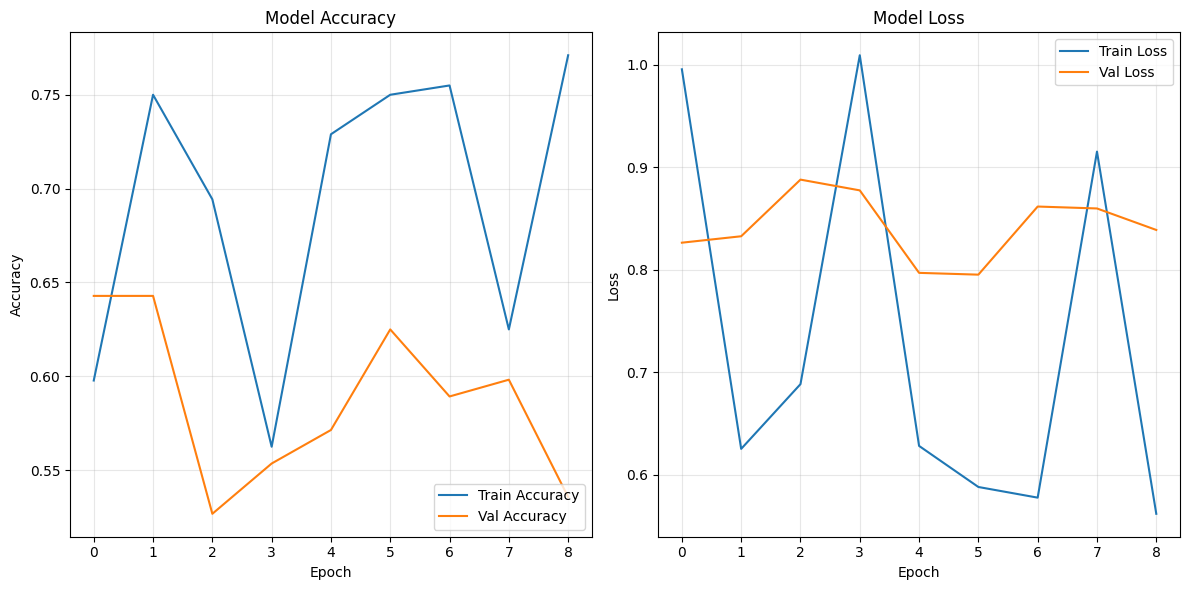

In [9]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(len(acc))
    
    plt.figure(figsize=(12, 6))
    
    # Plot Akurasi
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    
    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_history(history)


🔍 Evaluasi Model pada Data Test...
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step 

✅ Evaluasi selesai!
Total sampel test: 93
Total prediksi: 93
Total true labels: 93

📄 CLASSIFICATION REPORT
              precision    recall  f1-score   support

      benign     0.5942    0.9318    0.7257        44
   malignant     0.8333    0.5556    0.6667        36
      normal     0.0000    0.0000    0.0000        13

    accuracy                         0.6559        93
   macro avg     0.4758    0.4958    0.4641        93
weighted avg     0.6037    0.6559    0.6014        93


📊 OVERALL METRICS
Accuracy  : 0.6559 (65.59%)
Precision : 0.6037
Recall    : 0.6559
F1-Score  : 0.6014

📈 Per-Class F1-Scores:
  Benign: 0.7257
  Malignant: 0.6667
  Normal: 0.0000

✅ Evaluasi selesai!
Total sampel test: 93
Total prediksi: 93
Total true labels: 93

📄 CLASSIFICATION REPORT
              precision    recall  f1-score   support

      benign     0.5942    0.9318    0.7257        44

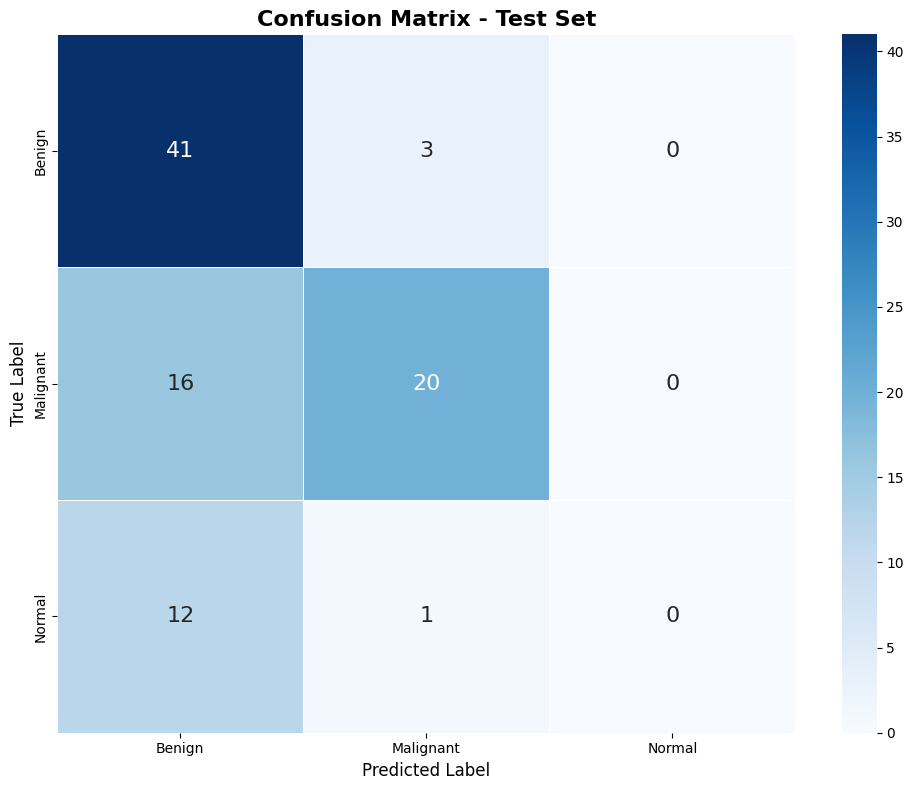

In [10]:
# ===================================================================
# EVALUASI MODEL PADA DATA TEST
# ===================================================================

print("🔍 Evaluasi Model pada Data Test...")

# Load model terbaik
best_model = tf.keras.models.load_model('best_model_densenet_fln.keras')

# Reset generator
test_generator.reset()

# Prediksi pada data test
test_steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
predictions = best_model.predict(test_generator, steps=test_steps, verbose=1)

# Dapatkan kelas prediksi dan kelas sebenarnya
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Pastikan jumlah prediksi sesuai
predicted_classes = predicted_classes[:len(true_classes)]

print(f"\n✅ Evaluasi selesai!")
print(f"Total sampel test: {test_generator.samples}")
print(f"Total prediksi: {len(predicted_classes)}")
print(f"Total true labels: {len(true_classes)}")

# Classification Report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average=None)
recall = recall_score(true_classes, predicted_classes, average=None)
f1 = f1_score(true_classes, predicted_classes, average=None)

precision_avg = precision_score(true_classes, predicted_classes, average='weighted')
recall_avg = recall_score(true_classes, predicted_classes, average='weighted')
f1_avg = f1_score(true_classes, predicted_classes, average='weighted')

print("\n" + "=" * 70)
print("📄 CLASSIFICATION REPORT")
print("=" * 70)
print(classification_report(true_classes, predicted_classes, target_names=class_names, digits=4))

print("\n" + "=" * 70)
print("📊 OVERALL METRICS")
print("=" * 70)
print(f"Accuracy  : {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision : {precision_avg:.4f}")
print(f"Recall    : {recall_avg:.4f}")
print(f"F1-Score  : {f1_avg:.4f}")

print(f"\n📈 Per-Class F1-Scores:")
for i, class_name in enumerate(class_names):
    print(f"  {class_name.capitalize()}: {f1[i]:.4f}")

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[c.capitalize() for c in class_names], 
            yticklabels=[c.capitalize() for c in class_names],
            linewidths=0.5, annot_kws={"size": 16})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - Test Set', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()
